In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database

Latest_Date = (session.query(Measurement.date).order_by(Measurement.date.desc()).first())

# Extract string from query object
Latest_Date = list(np.ravel(Latest_Date))[0]
# Date string to datetime object
Latest_Date = dt.datetime.strptime(Latest_Date, '%Y-%m-%d')

# Convert Year, Month, and Day as integers
Latest_Year = int(dt.datetime.strftime(Latest_Date, '%Y'))
Latest_Month = int(dt.datetime.strftime(Latest_Date, '%m'))
Latest_Day = int(dt.datetime.strftime(Latest_Date, '%d'))

# Minus 365 days
Year_Before365 = dt.date(Latest_Year, Latest_Month, Latest_Day) - dt.timedelta(days=365)

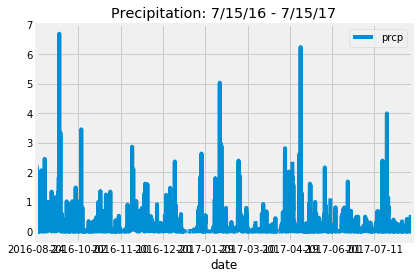

In [15]:
# Perform a query to retrieve the data and precipitation scores
Rain_Prec_Data = (session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > Year_Before365).order_by(Measurement.date).all())

# Save the query results as a Pandas DataFrame and set the index to the date column
Rain_df = pd.DataFrame(Rain_Prec_Data)
Rain_df = Rain_df.set_index('date')

# Sort the dataframe by date
Rain_df_sorted = Rain_df.sort_index(ascending=True)
# Use Pandas Plotting with Matplotlib to plot the data
Rain_df_sorted.plot(title="Precipitation: 7/15/16 - 7/15/17")
fig.savefig('Hawaii_Prec_Last_12_months.png', dpi=fig.dpi)

In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data
Rain_df_sorted.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [17]:
# Design a query to show how many stations are available in this dataset?
Count_Stations = session.query(Station).count()
print(f"Station Count: {Count_Stations}")

Station Count: 9


In [19]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
Station_Counts = (session.query(Measurement.station, func.count(Measurement.station))
                         .group_by(Measurement.station)
                        .order_by(func.count(Measurement.station).desc())
                        .all())
Station_ID = Station_Counts[0][0]
Station_Name = (session.query(Station.name)
                      .filter_by(station = Station_ID))
Station_Name = Station_Name[0][0]
print(f"The most active station is {Station_ID}: {Station_Name}.")

The most active station is USC00519281: WAIHEE 837.5, HI US.


In [22]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
# Find Lowest Temperature
Low_Temp = (session.query(Measurement.tobs)
                     .filter(Measurement.station == Station_ID)
                     .order_by(Measurement.tobs.asc())
                     .first())
Low_Temp = Low_Temp[0]
print(f"The lowest temperature recorded is {Low_Temp} degrees Farenheit.")

# Find Highest Temperature

High_Temp = (session.query(Measurement.tobs)
                      .filter(Measurement.station == Station_ID)
                      .order_by(Measurement.tobs.desc())
                      .first())
High_Temp  = High_Temp [0]
print(f"The highest temperature recorded is {High_Temp} degrees Farenheit.")

# Find Average Temperature
Avg_Temp = (session.query(func.avg(Measurement.tobs))
                  .filter(Measurement.station == Station_ID))
Avg_Temp = '{0:.3}'.format(Avg_Temp[0][0])
print(f"The average temperature recorded is {Avg_Temp} degrees Farenheit.")

The lowest temperature recorded there is 54.0 degrees Farenheit.
The highest temperature recorded there is 85.0 degrees Farenheit.
The average temperature recorded there is 71.7 degrees Farenheit.


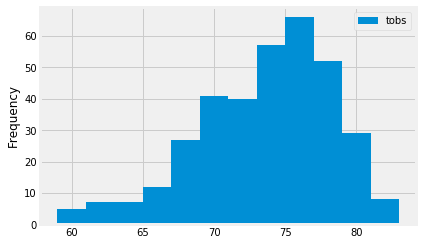

In [25]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

Temp_Data = (session.query(Measurement.date, Measurement.tobs)
                   .filter(Measurement.date > Year_Before365)
                   .filter(Measurement.station == Station_ID)
                   .order_by(Measurement.date)
                   .all())

# Convert object to data frame
Temp_df = pd.DataFrame(Temp_Data)
Temp_df = Temp_df.set_index('date')

Temp_df_sorted = Temp_df.sort_index(ascending=True)

# Plot with pandas
Temp_df_sorted.plot(kind='hist', bins=12)
fig.savefig('Histogram_Temperature.png', dpi=fig.dpi)

In [26]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
      # res = results.one()
       TMAX = res.max_tobs
       TMIN= res.min_tobs
       TAVG= res.avg_tobs
       Temp.append(TMAX)
       Temp.append(TMIN)
       Temp.append(TAVG)
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [28]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

print(calc_temps('2017-06-15', '2017-06-30'))

[(71.0, 77.01980198019803, 82.0)]


/Users/davidmariscal/opt/anaconda3/envs/PythonData/lib/python3.6/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import kernelapp as app


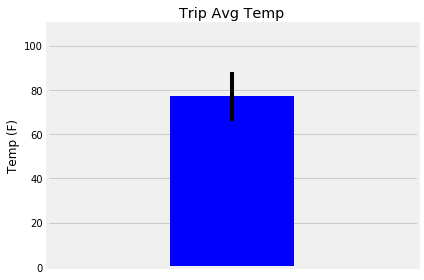

In [34]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
Trip_Temps = calc_temps('2017-06-15', '2017-06-30')

TAVE=Trip_Temps[0][1]
TMIN=Trip_Temps[0][0]
TMAX=Trip_Temps[0][2]


plt.bar( 1,TAVE, color = 'blue', yerr = TMAX-TMIN, align='center')
plt.xlim(-0.2, 2.2)
plt.ylim([0, 110])
plt.axes().get_xaxis().set_visible(False)
plt.title('Trip Avg Temp')
plt.ylabel("Temp (F)")
plt.tight_layout()
plt.show()
fig.savefig('Histogram_Temperature.png', dpi=fig.dpi)
fig.savefig('Trip_Avg_Temp.png', dpi=fig.dpi)

In [39]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
Stations_Lat_Lng_El = ([Station.station, Station.name, func.sum(Measurement.prcp), Station.latitude, Station.longitude,Station.elevation
])

Rain_Station = (session.query(*Stations_Lat_Lng_El)
                   .filter(Station.station == Measurement.station)
                   .filter(Measurement.date >= '2017-06-15')
                   .filter(Measurement.date <= '2017-06-30')
                   .group_by(Station.station)
                   .order_by(func.sum(Measurement.prcp).desc())
                   .all())

Rain_Station_df = pd.DataFrame(np.array(Rain_Station))

Rain_Station_df_Ren = Rain_Station_df.rename(columns={0: "Station", 1: "Location", 
                                                    2: "Total Rainfall", 3: "Latitude", 
                                                    4: "Longitude", 5: "Elevation"})

Rain_Station_df_Ren


,Station,Location,Total Rainfall,Latitude,Longitude,Elevation
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",5.479999999999999,21.3331,-157.8025,152.4
1,USC00519281,"WAIHEE 837.5, HI US",1.83,21.45167,-157.84888999999998,32.9
2,USC00513117,"KANEOHE 838.1, HI US",1.1900000000000004,21.4234,-157.8015,14.6
3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",0.88,21.5213,-157.8374,7.0
4,USC00519397,"WAIKIKI 717.2, HI US",0.21000000000000002,21.2716,-157.8168,3.0
5,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",0.13,21.33556,-157.71139,19.5
6,USC00517948,"PEARL CITY, HI US",0.12,21.3934,-157.9751,11.9


## Optional Challenge Assignment

In [40]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [44]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
# Set the start and end date of the trip
Start_Date = "2019-10-15"
End_Date = "2019-10-30"
Start_Num = int(Start_Date[-2:])
End_Num = int(End_Date[-2:])
Trip_Length = End_Num - Start_Num + 1
# Use the start and end date to create a range of dates
Start_Date = dt.datetime.strptime(Start_Date, '%Y-%m-%d')

# Loop through the list of %m-%d strings and calculate the normals for each date
Date_List = [dt.datetime.strftime(Start_Date + dt.timedelta(days = x), '%m-%d') 
            for x in range(0, Trip_Length)]
My_Trip_Normals = [daily_normals(date) for date in Date_List]

My_Trip_Normals

[[(67.0, 75.63461538461539, 82.0)],
 [(67.0, 75.59183673469387, 81.0)],
 [(65.0, 75.07843137254902, 83.0)],
 [(65.0, 75.0, 83.0)],
 [(65.0, 73.24489795918367, 81.0)],
 [(67.0, 74.79629629629629, 82.0)],
 [(66.0, 74.96078431372548, 82.0)],
 [(66.0, 74.84313725490196, 81.0)],
 [(66.0, 75.74468085106383, 84.0)],
 [(69.0, 74.98039215686275, 81.0)],
 [(68.0, 75.0, 81.0)],
 [(68.0, 75.17307692307692, 81.0)],
 [(64.0, 75.12, 81.0)],
 [(68.0, 74.75471698113208, 82.0)],
 [(68.0, 74.88679245283019, 81.0)],
 [(64.0, 74.66, 81.0)]]

In [45]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
My_Trip_Normals = [np.array(normal[0]) for normal in My_Trip_Normals]

# Normals list into a data frame
Normals_df = pd.DataFrame(My_Trip_Normals)
# Add date column
Normals_df["Date"] = Date_List
# Set index  
Normals_df = Normals_df.set_index("Date")
Normals_df_ren = Normals_df.rename(columns={0: "Low Temp", 1: "Avg Temp", 2: "High Temp"})

Normals_df_ren

,Low Temp,Avg Temp,High Temp
Date,,,
10-15,67.0,75.634615,82.0
10-16,67.0,75.591837,81.0
10-17,65.0,75.078431,83.0
10-18,65.0,75.000000,83.0
10-19,65.0,73.244898,81.0
10-20,67.0,74.796296,82.0
10-21,66.0,74.960784,82.0
10-22,66.0,74.843137,81.0
10-23,66.0,75.744681,84.0


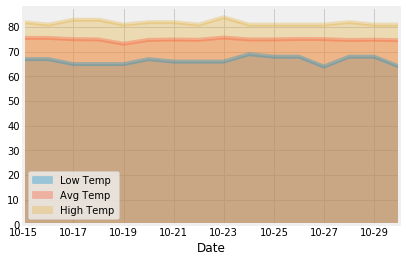

In [46]:
# Plot with Pandas

Normals_df_ren.plot.area(stacked=False, alpha=.333)
plt.savefig('Daily_normals_Temperature_Hawaii.png', bbox_inches = 'tight')